In [2]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
import shap

In [3]:
data = pd.read_csv('/Users/prateekanand/Desktop/CS148/Travel-Purpose-Prediction/csv/trippub.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
print(data.head())
print(data.shape)

    HOUSEID  PERSONID  TDTRPNUM  STRTTIME  ENDTIME  TRVLCMIN  TRPMILES  TRPTRANS  TRPACCMP  TRPHHACC  VEHID  TRWAITTM  NUMTRANS  TRACCTM  DROP_PRK  TREGRTM  WHODROVE  WHYFROM  LOOP_TRIP  TRPHHVEH  HHMEMDRV  HH_ONTD  NONHHCNT  NUMONTRP  PSGR_FLG  PUBTRANS TRIPPURP  DWELTIME  TDWKND  VMT_MILE  DRVR_FLG  WHYTRP1S  ONTD_P1  ONTD_P2  ONTD_P3  ONTD_P4  ONTD_P5  ONTD_P6  ONTD_P7  ONTD_P8  ONTD_P9  ONTD_P10  ONTD_P11  ONTD_P12  ONTD_P13      TDCASEID  TRACC_WLK  TRACC_POV  TRACC_BUS  TRACC_CRL  TRACC_SUB  TRACC_OTH  TREGR_WLK  TREGR_POV  TREGR_BUS  TREGR_CRL  TREGR_SUB  TREGR_OTH  WHYTO  TRAVDAY  HOMEOWN  HHSIZE  HHVEHCNT  HHFAMINC  DRVRCNT HHSTATE  HHSTFIPS  NUMADLT  WRKCOUNT  TDAYDATE  HHRESP  LIF_CYC  MSACAT  MSASIZE  RAIL  URBAN  URBANSIZE  URBRUR  GASPRICE  CENSUS_D  CENSUS_R  CDIVMSAR  HH_RACE  HH_HISP HH_CBSA  SMPLSRCE  R_AGE  EDUC  R_SEX  PRMACT  PROXY  WORKER  DRIVER      WTTRDFIN  WHYTRP90   TRPMILAD  R_AGE_IMP  R_SEX_IMP  VEHTYPE OBHUR DBHUR  OTHTNRNT  OTPPOPDN  OTRESDN  OTEEMPDN  O

Preprocessing

In [4]:
# Drop columns related to trip purpose, also drop HH_CBSA because most values are XXXXX and cannot impute those
drop = ['WHYTO', 'WHYFROM', 'TRIPPURP', 'WHYTRP1S', 'WHYTRP90', 'HH_CBSA']
y = data['WHYTRP1S']
X = data.drop(columns=drop, axis=1)

categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print(categorical_cols)

categorical_idx = [X.columns.get_loc(col) for col in categorical_cols]
print(categorical_idx)

print(X.head())
np.set_printoptions(threshold=sys.maxsize)
print(np.array(X.columns))
print(len(np.array(X.columns)))
data = {'Features' : np.array(X.columns)}
df = pd.DataFrame(data)
df.to_csv('features.csv', index=False)

['HHSTATE', 'OBHUR', 'DBHUR']
[61, 93, 94]
    HOUSEID  PERSONID  TDTRPNUM  STRTTIME  ENDTIME  TRVLCMIN  TRPMILES  TRPTRANS  TRPACCMP  TRPHHACC  VEHID  TRWAITTM  NUMTRANS  TRACCTM  DROP_PRK  TREGRTM  WHODROVE  LOOP_TRIP  TRPHHVEH  HHMEMDRV  HH_ONTD  NONHHCNT  NUMONTRP  PSGR_FLG  PUBTRANS  DWELTIME  TDWKND  VMT_MILE  DRVR_FLG  ONTD_P1  ONTD_P2  ONTD_P3  ONTD_P4  ONTD_P5  ONTD_P6  ONTD_P7  ONTD_P8  ONTD_P9  ONTD_P10  ONTD_P11  ONTD_P12  ONTD_P13      TDCASEID  TRACC_WLK  TRACC_POV  TRACC_BUS  TRACC_CRL  TRACC_SUB  TRACC_OTH  TREGR_WLK  TREGR_POV  TREGR_BUS  TREGR_CRL  TREGR_SUB  TREGR_OTH  TRAVDAY  HOMEOWN  HHSIZE  HHVEHCNT  HHFAMINC  DRVRCNT HHSTATE  HHSTFIPS  NUMADLT  WRKCOUNT  TDAYDATE  HHRESP  LIF_CYC  MSACAT  MSASIZE  RAIL  URBAN  URBANSIZE  URBRUR  GASPRICE  CENSUS_D  CENSUS_R  CDIVMSAR  HH_RACE  HH_HISP  SMPLSRCE  R_AGE  EDUC  R_SEX  PRMACT  PROXY  WORKER  DRIVER      WTTRDFIN   TRPMILAD  R_AGE_IMP  R_SEX_IMP  VEHTYPE OBHUR DBHUR  OTHTNRNT  OTPPOPDN  OTRESDN  OTEEMPDN  OBHTNRNT  O

In [6]:
# Invalid/missing values are reported as negative values in the dataframe or the string '-9'
X = X.applymap(lambda x: np.nan if ((isinstance(x, (int, float)) and x < 0) or (isinstance(x, str) and x == '-9')) else x)

# Replace these two columns with mode since they are categorical
mode = X['OBHUR'].mode()
X['OBHUR'].fillna(mode, inplace=True)
mode = X['DBHUR'].mode()
X['DBHUR'].fillna(mode, inplace=True)

print(X.head())

    HOUSEID  PERSONID  TDTRPNUM  STRTTIME  ENDTIME  TRVLCMIN  TRPMILES  TRPTRANS  TRPACCMP  TRPHHACC  VEHID  TRWAITTM  NUMTRANS  TRACCTM  DROP_PRK  TREGRTM  WHODROVE  LOOP_TRIP  TRPHHVEH  HHMEMDRV  HH_ONTD  NONHHCNT  NUMONTRP  PSGR_FLG  PUBTRANS  DWELTIME  TDWKND  VMT_MILE  DRVR_FLG  ONTD_P1  ONTD_P2  ONTD_P3  ONTD_P4  ONTD_P5  ONTD_P6  ONTD_P7  ONTD_P8  ONTD_P9  ONTD_P10  ONTD_P11  ONTD_P12  ONTD_P13      TDCASEID  TRACC_WLK  TRACC_POV  TRACC_BUS  TRACC_CRL  TRACC_SUB  TRACC_OTH  TREGR_WLK  TREGR_POV  TREGR_BUS  TREGR_CRL  TREGR_SUB  TREGR_OTH  TRAVDAY  HOMEOWN  HHSIZE  HHVEHCNT  HHFAMINC  DRVRCNT HHSTATE  HHSTFIPS  NUMADLT  WRKCOUNT  TDAYDATE  HHRESP  LIF_CYC  MSACAT  MSASIZE  RAIL  URBAN  URBANSIZE  URBRUR  GASPRICE  CENSUS_D  CENSUS_R  CDIVMSAR  HH_RACE  HH_HISP  SMPLSRCE  R_AGE  EDUC  R_SEX  PRMACT  PROXY  WORKER  DRIVER      WTTRDFIN   TRPMILAD  R_AGE_IMP  R_SEX_IMP  VEHTYPE OBHUR DBHUR  OTHTNRNT  OTPPOPDN  OTRESDN  OTEEMPDN  OBHTNRNT  OBPPOPDN  OBRESDN  DTHTNRNT  DTPPOPDN  DTRES

In [7]:
# Then impute the numerical nan values with mean
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()

for col in numerical_cols:
    mean = X[col].mean()
    X[col].fillna(mean, inplace=True)

print(X.head())

    HOUSEID  PERSONID  TDTRPNUM  STRTTIME  ENDTIME  TRVLCMIN  TRPMILES  TRPTRANS  TRPACCMP  TRPHHACC  VEHID   TRWAITTM  NUMTRANS   TRACCTM  DROP_PRK    TREGRTM  WHODROVE  LOOP_TRIP  TRPHHVEH  HHMEMDRV  HH_ONTD  NONHHCNT  NUMONTRP  PSGR_FLG  PUBTRANS    DWELTIME  TDWKND  VMT_MILE  DRVR_FLG  ONTD_P1  ONTD_P2  ONTD_P3   ONTD_P4   ONTD_P5   ONTD_P6   ONTD_P7   ONTD_P8   ONTD_P9  ONTD_P10  ONTD_P11  ONTD_P12  ONTD_P13      TDCASEID  TRACC_WLK  TRACC_POV  TRACC_BUS  TRACC_CRL  TRACC_SUB  TRACC_OTH  TREGR_WLK  TREGR_POV  TREGR_BUS  TREGR_CRL  TREGR_SUB  TREGR_OTH  TRAVDAY  HOMEOWN  HHSIZE  HHVEHCNT  HHFAMINC  DRVRCNT HHSTATE  HHSTFIPS  NUMADLT  WRKCOUNT  TDAYDATE  HHRESP  LIF_CYC  MSACAT  MSASIZE  RAIL  URBAN  URBANSIZE  URBRUR  GASPRICE  CENSUS_D  CENSUS_R  CDIVMSAR  HH_RACE  HH_HISP  SMPLSRCE  R_AGE  EDUC  R_SEX  PRMACT  PROXY  WORKER  DRIVER      WTTRDFIN   TRPMILAD  R_AGE_IMP  R_SEX_IMP  VEHTYPE OBHUR DBHUR  OTHTNRNT  OTPPOPDN  OTRESDN  OTEEMPDN  OBHTNRNT  OBPPOPDN  OBRESDN  DTHTNRNT  DTP

In [8]:
# One-hot encode categorical features
X = pd.get_dummies(X, columns = categorical_cols)
X.replace({True: 1, False: 0}, inplace=True)

print(X.shape)
print(X.head())

(923572, 167)
    HOUSEID  PERSONID  TDTRPNUM  STRTTIME  ENDTIME  TRVLCMIN  TRPMILES  TRPTRANS  TRPACCMP  TRPHHACC  VEHID   TRWAITTM  NUMTRANS   TRACCTM  DROP_PRK    TREGRTM  WHODROVE  LOOP_TRIP  TRPHHVEH  HHMEMDRV  HH_ONTD  NONHHCNT  NUMONTRP  PSGR_FLG  PUBTRANS    DWELTIME  TDWKND  VMT_MILE  DRVR_FLG  ONTD_P1  ONTD_P2  ONTD_P3   ONTD_P4   ONTD_P5   ONTD_P6   ONTD_P7   ONTD_P8   ONTD_P9  ONTD_P10  ONTD_P11  ONTD_P12  ONTD_P13      TDCASEID  TRACC_WLK  TRACC_POV  TRACC_BUS  TRACC_CRL  TRACC_SUB  TRACC_OTH  TREGR_WLK  TREGR_POV  TREGR_BUS  TREGR_CRL  TREGR_SUB  TREGR_OTH  TRAVDAY  HOMEOWN  HHSIZE  HHVEHCNT  HHFAMINC  DRVRCNT  HHSTFIPS  NUMADLT  WRKCOUNT  TDAYDATE  HHRESP  LIF_CYC  MSACAT  MSASIZE  RAIL  URBAN  URBANSIZE  URBRUR  GASPRICE  CENSUS_D  CENSUS_R  CDIVMSAR  HH_RACE  HH_HISP  SMPLSRCE  R_AGE  EDUC  R_SEX  PRMACT  PROXY  WORKER  DRIVER      WTTRDFIN   TRPMILAD  R_AGE_IMP  R_SEX_IMP  VEHTYPE  OTHTNRNT  OTPPOPDN  OTRESDN  OTEEMPDN  OBHTNRNT  OBPPOPDN  OBRESDN  DTHTNRNT  DTPPOPDN 

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [44]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(alpha=0.001)
mlp.fit(X_train, y_train)

dump(mlp, 'mlp_0.001.model')

['mlp_0.001.model']

In [45]:
from sklearn.metrics import accuracy_score
y_pred = mlp.predict(X_test)

print(accuracy_score(y_test, y_pred))

0.6691984949787511


<Figure size 1200x600 with 0 Axes>

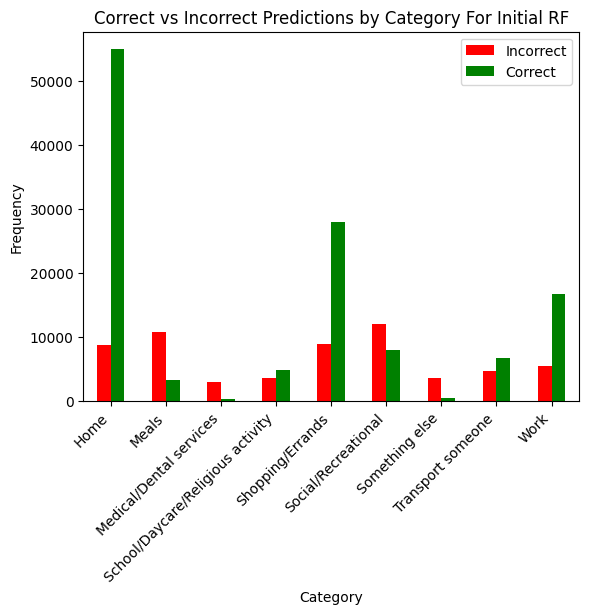

In [24]:
whytrip1s_map_to_string = {
    '1':'Home', 
    '10':'Work', 
    '20':'School/Daycare/Religious activity',
    '30':'Medical/Dental services',
    '40':'Shopping/Errands',
    '50':'Social/Recreational',
    '70':'Transport someone',
    '80':'Meals',
    '97':'Something else'
}

results_df = pd.DataFrame({
    'True_Labels': y_test,
    'Predicted_Labels': y_pred,
    'Correct': y_test == y_pred,
    'Category': y_test.astype(str).map(whytrip1s_map_to_string)
})

# Group by category and correctness, count occurrences
grouped_results = results_df.groupby(['Category', 'Correct']).size().unstack()

# Plot grouped bar graph
plt.figure(figsize=(12, 6))
grouped_results.plot(kind='bar', stacked=False, color=['red', 'green'])
plt.title('Correct vs Incorrect Predictions by Category For Initial RF')
plt.ylabel('Frequency')
plt.xlabel('Category')
plt.xticks(rotation=45, ha='right')
plt.legend(['Incorrect', 'Correct'])
plt.show()

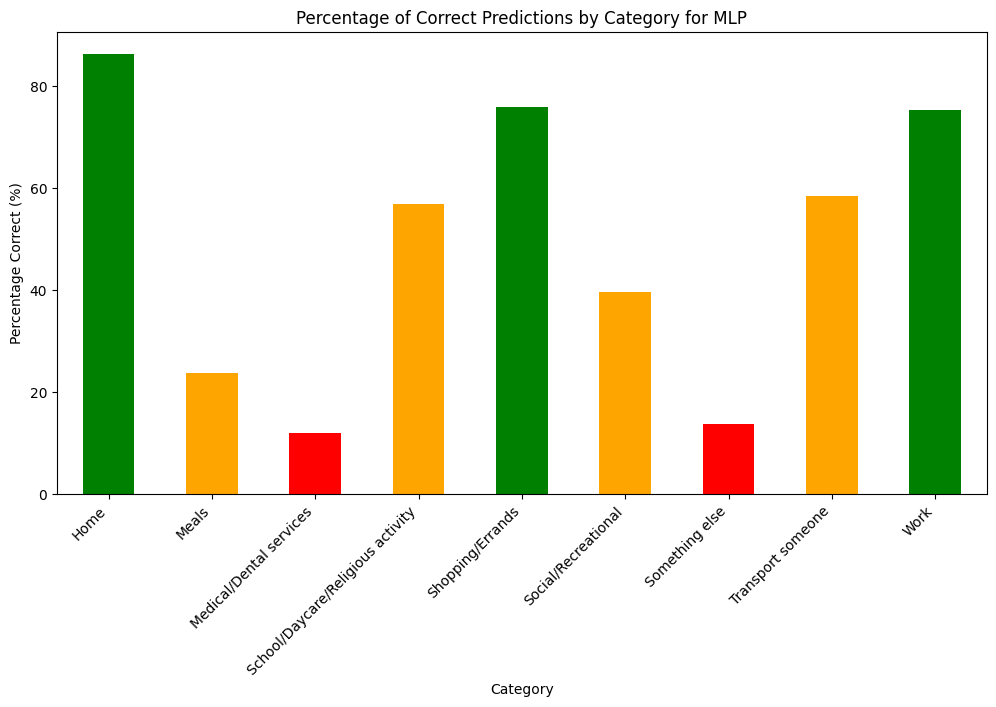

In [26]:
# Calculate the percentage of correct predictions for each category
grouped_results['Percent_Correct'] = (grouped_results[True] / (grouped_results[True] + grouped_results[False]))*100
color_mapping = {
    'red': lambda x: x < 20,
    'orange': lambda x: 20 <= x <= 60,
    'green': lambda x: x > 60
}
colors = [next(key for key, condition in color_mapping.items() if condition(percent)) for percent in grouped_results['Percent_Correct']]

# Plot bar graph for percentage of correct predictions
plt.figure(figsize=(12, 6))
grouped_results['Percent_Correct'].plot(kind='bar', color=colors)
plt.title('Percentage of Correct Predictions by Category for MLP')
plt.ylabel('Percentage Correct (%)')
plt.xlabel('Category')
plt.xticks(rotation=45, ha='right')
plt.show()

In [35]:
print(X_train.shape)
print(y_train.shape)
np.set_printoptions(threshold=False)

y_train = y_train.values

# sampling = np.sort(np.random.choice(len(X_train),100000,replace=False))
# X_train = X_train[sampling]
# y_train = y_train[sampling]

kf = KFold(n_splits=5, shuffle=True, random_state=1)

error_means = []
accuracy_means = []
alphas = [0.001, 0.01, 0.1, 1.0, 10.0]
for a in alphas:
    print(a)
    error = []
    accuracy = []
    for fold_num, (train_index, val_index) in enumerate(kf.split(X_train, y_train)):
        print(fold_num)
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]

        model = MLPClassifier(alpha=a)

        model.fit(X_fold_train, y_fold_train)
        y_pred = model.predict(X_fold_val)
        error.append(mean_squared_error(y_fold_val, y_pred))
        accuracy.append(accuracy_score(y_fold_val, y_pred))

        

    error_means.append(np.mean(error))
    accuracy_means.append(np.mean(accuracy))

print(error_means)

(738857, 167)
(738857,)
0.001
0


/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2


/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


3


/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.01
0


/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


1


/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


2
3


/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


4


/opt/homebrew/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.1
0
1
2
3
4
1.0
0
1
2
3
4
10.0
0
1
2
3
4
[622.3756099999999, 616.2367099999999, 600.3227999999999, 632.97709, 827.7230000000002]


In [36]:
print(accuracy_means)

[0.62115, 0.62242, 0.63022, 0.6227599999999999, 0.54897]


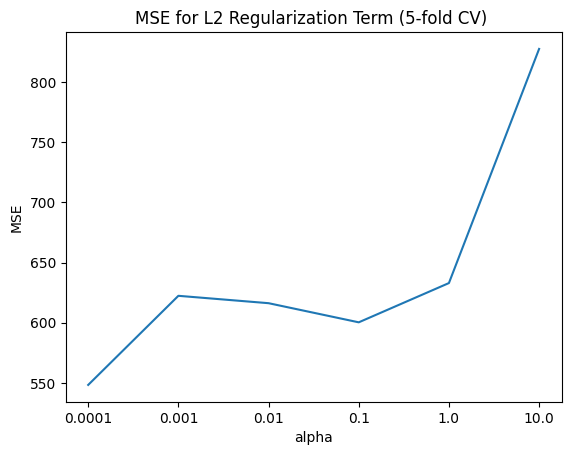

In [24]:
error_means = [548.2582099999999, 622.3756099999999, 616.2367099999999, 600.3227999999999, 632.97709, 827.7230000000002]
plt.title("MSE for L2 Regularization Term (5-fold CV) ")
plt.ylabel("MSE")
plt.xlabel("alpha")
plt.xticks(ticks=[0, 1, 2, 3, 4, 5], labels=[0.0001, 0.001, 0.01, 0.1, 1.0, 10.0])
plt.plot(error_means)

In [10]:
import shap
mlp = load('mlp.model')
# Use SHAP to explain the model's predictions
def model_predict_proba(input_data):
    return mlp.predict_proba(input_data)

sampling = np.sort(np.random.choice(len(X_test),1000,replace=False))
X_test = X_test[sampling]

# Use SHAP to explain the model's predictions
explainer = shap.Explainer(model_predict_proba, X_train)
shap_values = explainer.shap_values(X_test)

# Print feature importances
# shap.summary_plot(shap_values, X_test, feature_names=data.feature_names, plot_type="bar")

PermutationExplainer explainer: 1001it [02:07,  7.33it/s]                          


[[[-2.32279249e-02 -7.84483168e-03  2.38008449e-03 ... -2.16775101e-03
    1.12051972e-02 -3.27669432e-04]
  [-4.53674870e-03  4.82610355e-03 -1.13392750e-04 ...  2.41295169e-03
   -2.08206578e-03 -3.73468463e-03]
  [-1.51401641e-02 -8.84183941e-04  2.32159143e-03 ...  5.71704364e-04
    1.15302369e-02  7.95314121e-04]
  ...
  [ 7.11887976e-03 -3.56779490e-03  7.32688919e-04 ... -1.36149732e-03
   -1.09976176e-02  1.07048784e-03]
  [ 1.10486919e-02  5.69085701e-03 -1.48783463e-03 ...  1.35891897e-03
    1.68437364e-02 -3.34948834e-03]
  [ 6.51531168e-03 -9.56099308e-03 -5.62039623e-05 ...  5.86112715e-06
   -1.25115656e-03 -6.51381820e-04]]

 [[ 4.20441653e-03  1.06315301e-03 -2.15772749e-03 ...  1.34544297e-03
   -1.71194870e-03  3.69219664e-04]
  [ 4.85106596e-03  4.02036251e-03 -1.08793723e-03 ...  4.18441092e-04
   -1.39448734e-03 -7.60137929e-04]
  [ 6.94237687e-03 -5.10757483e-04 -2.25756531e-03 ...  3.01523920e-04
   -3.19801605e-03  1.19231782e-03]
  ...
  [-5.06022414e-03 -1.1

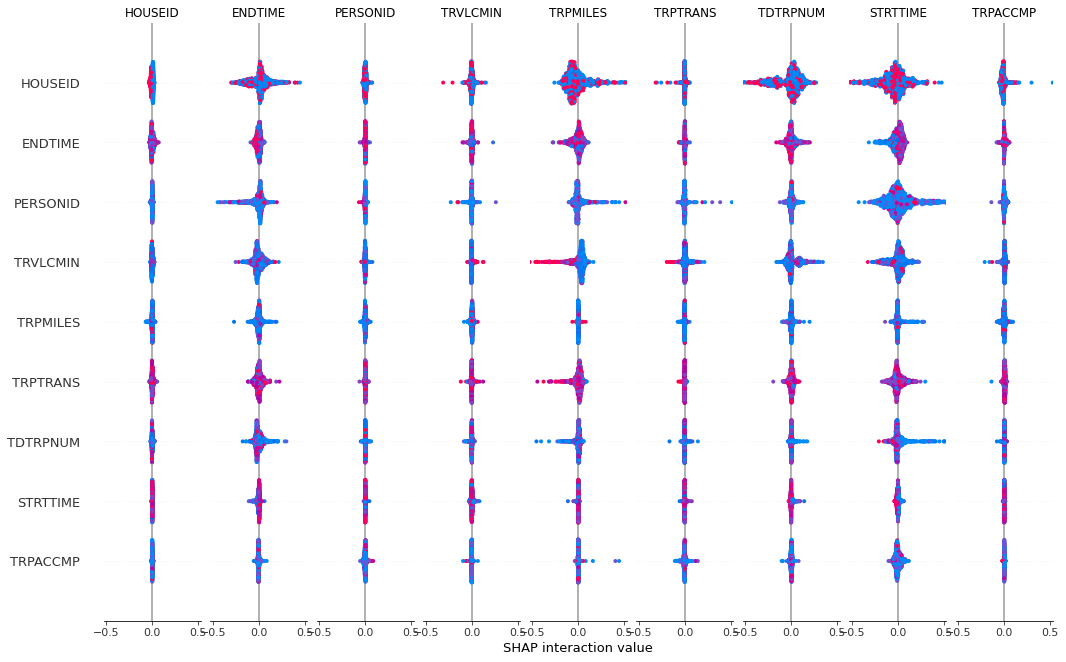

In [16]:
import matplotlib
np.set_printoptions(threshold=False)
print(shap_values)
print(shap_values.shape)
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar", max_display=10)